# Tree based models

## Why Tree-Based Models for Regression?

**💡 Context:** Tree-based models revolutionize regression by abandoning the assumption of linear relationships. Instead of fitting straight lines through data, they create decision boundaries that split the feature space into regions, each with its own prediction. This flexibility allows them to capture complex, non-linear patterns that linear models miss entirely.

**Key Advantages:**

- No linearity assumptions: Can model any relationship shape.
- Handles interactions automatically: Discovers feature combinations without manual engineering.
- Mixed data types: Works with numerical and categorical features seamlessly.
- Interpretable decisions: Can trace exact reasoning for any prediction.

**When Trees Excel:**

- Non-linear relationships between features and target.
- Complex feature interactions are important.
- Mix of numerical and categorical variables.
- Need interpretable model decisions.

In [38]:
import time
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import r2_score
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.monitor_model import monitor_model
from utils.complete_model_review import complete_model_review
from utils.tree_model_diagnostics import tree_model_diagnostics
from utils.TreeEnsembleProject import TreeEnsembleProject

# Read the data
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

In [23]:
X_train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,49576.729875,50.580625,0.507250,0.496750,50.170000,50338.934500,5.520750,5.516000,2005.556250,0.497375,0.499250,5042.218750,5022.901125,550.559500,0.499875,4.972125
std,28557.941008,28.814298,0.499979,0.500021,28.938586,28907.555953,2.876518,2.861209,9.317292,0.500024,0.500031,2878.466674,2899.771979,262.338146,0.500031,3.163281
min,89.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,1.000000,1.000000,100.000000,0.000000,0.000000
25%,25019.500000,26.000000,0.000000,0.000000,25.000000,25223.500000,3.000000,3.000000,1997.000000,0.000000,0.000000,2566.000000,2500.750000,325.000000,0.000000,2.000000
50%,49819.000000,51.000000,1.000000,0.000000,50.000000,50693.000000,6.000000,5.000000,2006.000000,0.000000,0.000000,5140.500000,5056.000000,549.000000,0.000000,5.000000
75%,73984.250000,75.000000,1.000000,1.000000,76.000000,75592.500000,8.000000,8.000000,2014.000000,1.000000,1.000000,7523.250000,7534.250000,777.000000,1.000000,8.000000
max,99952.000000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.000000,1.000000,1.000000,10000.000000,10000.000000,1000.000000,1.000000,10.000000


In [25]:
models = {
    "DecisionTree": DecisionTreeRegressor(max_depth=5),
    "RandomForest": RandomForestRegressor(
        n_estimators=100, max_depth=5, random_state=42
    ),  # Slow as fu**
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "DGBoost": XGBRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
}
for name, model in models.items():
    model.fit(X_train, y_train["price"])

    score = cross_val_score(
        model, X_train, y_train["price"], cv=5
    ).mean()
    print(f"{name}: {score:.3f}")

DecisionTree: 0.999
RandomForest: 1.000
ExtraTrees: 0.998
GradientBoosting: 1.000
DGBoost: 1.000


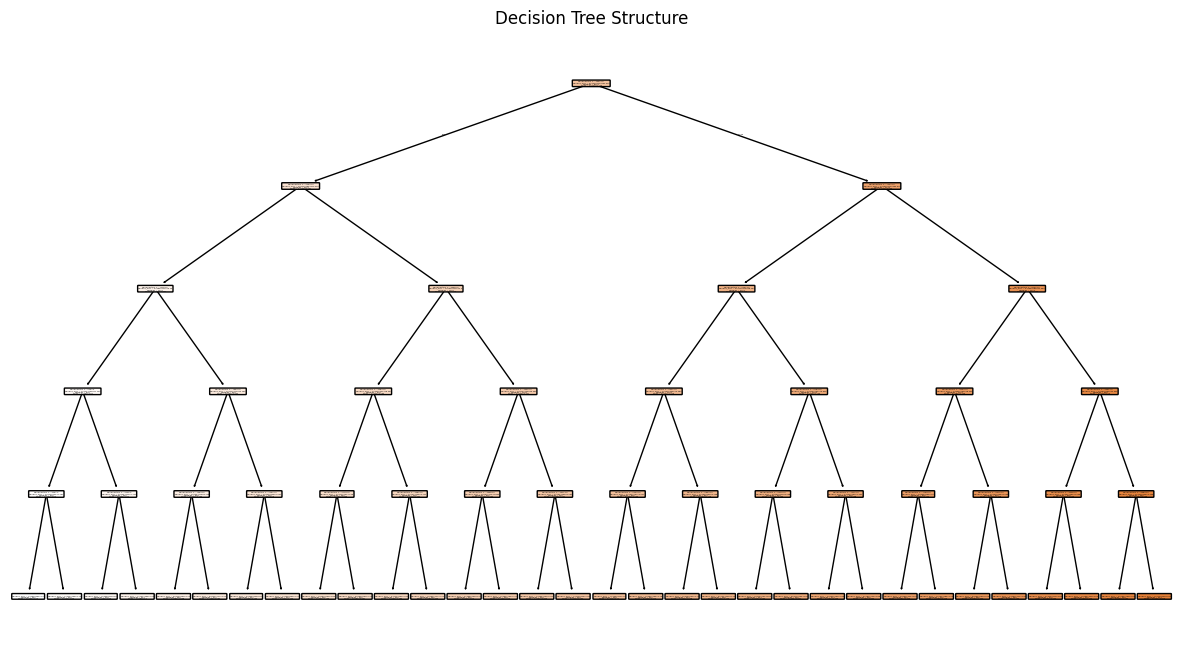

In [26]:
models["DecisionTree"].fit(X_train, y_train)

# Visualize tree structure
plt.figure(figsize=(15, 8))
plot_tree(
    models["DecisionTree"], feature_names=X_train.columns, filled=True, rounded=True
)
plt.title("Decision Tree Structure")
plt.show()

## Controlling Overfitting in Decision Trees

Single decision trees are notorious overfitters - without constraints, they'll create a unique leaf for every training sample, achieving perfect training accuracy but terrible generalization. Controlling tree complexity through hyperparameters is essential for building useful models that perform well on new data.
Key Hyperparameters:

- **max_depth**: Limits tree height (typical range: 3-10)
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples required in each leaf
- **max_features**: Fraction of features considered for each split

In [27]:
depths = [1, 3, 5, 6, 7, 10, None]

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    cv_scores = cross_val_score(tree, X_train, y_train, cv=5)
    print(f"  Depth {depth}: CV R² = {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

  Depth 1: CV R² = 0.744 ± 0.004
  Depth 3: CV R² = 0.984 ± 0.000
  Depth 5: CV R² = 0.999 ± 0.000
  Depth 6: CV R² = 1.000 ± 0.000
  Depth 7: CV R² = 1.000 ± 0.000
  Depth 10: CV R² = 1.000 ± 0.000
  Depth None: CV R² = 1.000 ± 0.000


## Random Forest - Ensemble Power

Random Forest combines many decision trees, each trained on a different subset of data and features. This ensemble approach reduces overfitting while maintaining the flexibility of individual trees. Think of it as consulting multiple experts who each see slightly different perspectives on the same problem - their combined wisdom is more reliable than any single opinion.

**How Random Forest Works:**

- Bootstrap sampling: Each tree trains on a random sample with replacement.
- Feature randomness: Each split considers only a random subset of features.
- Independent training: Trees don't influence each other.
- Averaging predictions: Final prediction is the mean of all tree predictions.

**Why It Works:**

- Reduces variance: Averaging multiple models smooths out individual quirks.
- Maintains low bias: Individual trees can still capture complex patterns.
- Handles overfitting: Randomness prevents trees from memorizing training data.

Top 10 Most Important Features:
              feature    importance
0        squareMeters  9.999994e-01
11           basement  3.185301e-07
1       numberOfRooms  1.035792e-07
4              floors  8.613315e-08
12              attic  2.214392e-08
6       cityPartRange  6.945860e-09
14     hasStorageRoom  5.998493e-09
10  hasStormProtector  3.168879e-09
7       numPrevOwners  2.483791e-09
5            cityCode  2.214349e-09


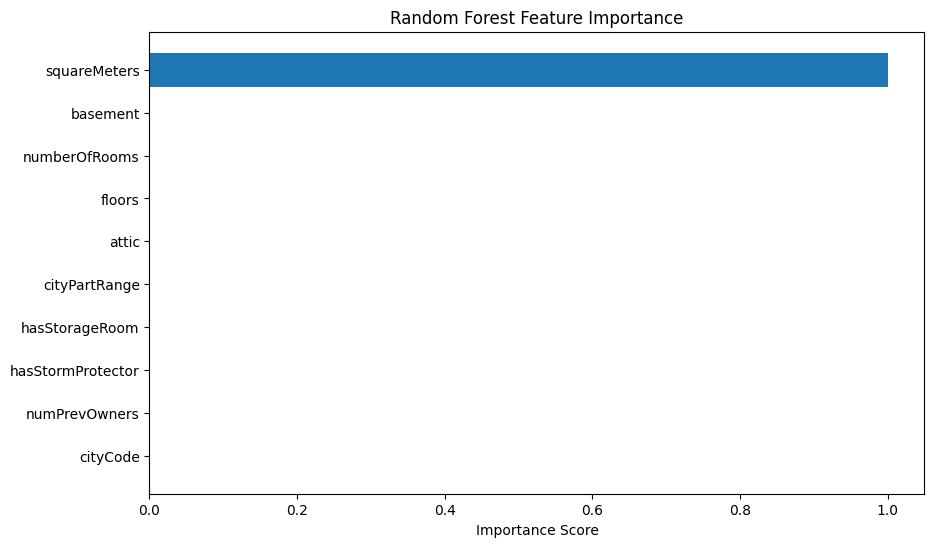

In [28]:
## Get feature importance

importance_df = pd.DataFrame(
    {
        "feature": X_train.columns,
        "importance": models["ExtraTrees"].feature_importances_,
    }
).sort_values("importance", ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Visualize importance
plt.figure(figsize=(10, 6))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features["importance"])
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Importance Score")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## Gradient Boosting Fundamentals

Gradient Boosting takes a fundamentally different ensemble approach: instead of training independent trees, it builds them sequentially, with each new tree specifically designed to correct the errors of the previous ensemble. This creates a powerful learning system that gradually improves predictions through focused error correction.

**Boosting Process:**

- **Start simple:** Begin with basic model (often just the mean).
- **Calculate errors:** Find where current ensemble fails.
- **Train corrector:** New tree targets these specific errors.
- **Add with shrinkage:** Combine new tree with reduced weight.
- **Repeat:** Continue until performance plateaus or criteria met.


**Key Concepts:**

- **Sequential learning:** Each tree builds on previous mistakes.
- **Learning rate:** Controls how much each tree contributes.
- **Shrinkage:** Prevents any single tree from dominating.
- **Early stopping:** Halt training when validation performance stops improving.

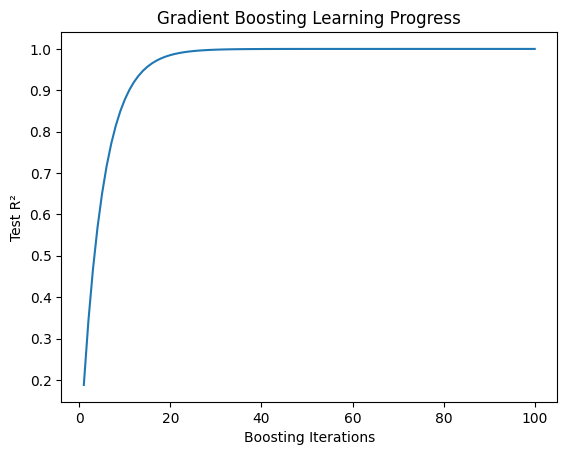

In [29]:
# Show learning progress
test_scores = []
for i, pred in enumerate(models["GradientBoosting"].staged_predict(X_test)):
    score = r2_score(y_test, pred)
    test_scores.append(score)

plt.plot(range(1, len(test_scores) + 1), test_scores)
plt.xlabel("Boosting Iterations")
plt.ylabel("Test R²")
plt.title("Gradient Boosting Learning Progress")
plt.show()

In [30]:
for name, model in models.items():
    pred = model.predict(X_test)
    print(f"{name} R²: {r2_score(y_test, pred):.3f}")

    # Feature importance
    xgb_importance = pd.DataFrame(
        {"feature": X_train.columns, "importance": model.feature_importances_}
    ).sort_values("importance", ascending=False)
    print(f"\nTop 5 {name} Features:")
    print(xgb_importance.head())
    print("\n" * 3)

DecisionTree R²: 0.999

Top 5 DecisionTree Features:
         feature  importance
0   squareMeters         1.0
1  numberOfRooms         0.0
2        hasYard         0.0
3        hasPool         0.0
4         floors         0.0




RandomForest R²: 0.999

Top 5 RandomForest Features:
         feature  importance
0   squareMeters         1.0
1  numberOfRooms         0.0
2        hasYard         0.0
3        hasPool         0.0
4         floors         0.0




ExtraTrees R²: 0.998

Top 5 ExtraTrees Features:
          feature    importance
0    squareMeters  9.999994e-01
11       basement  3.185301e-07
1   numberOfRooms  1.035792e-07
4          floors  8.613315e-08
12          attic  2.214392e-08




GradientBoosting R²: 1.000

Top 5 GradientBoosting Features:
         feature    importance
0   squareMeters  9.999994e-01
4         floors  1.662455e-07
2        hasYard  8.815841e-08
3        hasPool  6.857463e-08
13        garage  4.773374e-08




DGBoost R²: 1.000

Top 5 DGBoost Features:

## Hyperparameter Tuning for Tree Ensembles

**Context:** Tree-based ensemble models have many hyperparameters that significantly impact performance. Systematic tuning can dramatically improve results, but the parameter space is large and interactions are complex. Understanding which parameters matter most and efficient search strategies is crucial for practical success.

### Key Parameters by Model:

**Random Forest:**

- n_estimators: Number of trees (more is usually better, with diminishing returns).
- max_depth: Tree complexity control.
- max_features: Feature subset size for splits.

**Gradient Boosting:**

- learning_rate: Step size for each tree contribution.
- n_estimators: Number of boosting rounds.
- max_depth: Individual tree complexity.

**Tuning Strategy:**

- Start simple: Begin with default parameters.
- Grid search: Systematic parameter exploration.
- Random search: Efficient for high-dimensional spaces.
- Sequential tuning: Optimize parameter groups separately.

In [32]:
# Random Forest tuning
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10, 15],
    "max_features": ["sqrt", "log2", 0.5],
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42), rf_params, cv=9, scoring="r2", n_jobs=-3
)
rf_grid.fit(X_train, y_train["price"])
print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best RF score: {rf_grid.best_score_:.3f}")

Best RF params: {'max_depth': 15, 'max_features': 0.5, 'n_estimators': 200}
Best RF score: 1.000


In [33]:
results = []
for name, model in models.items():
    # Time training
    start_time = time.time()
    model.fit(X_train, y_train["price"])
    train_time = time.time() - start_time

    # Evaluate performance
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test["price"], y_pred)

    results.append({"Model": name, "R²": r2, "Train_Time": train_time})

comparison_df = pd.DataFrame(results)
print("Model Comparison:")
print(comparison_df.round(3))

Model Comparison:
              Model     R²  Train_Time
0      DecisionTree  0.999       0.028
1      RandomForest  0.999       1.546
2        ExtraTrees  0.998       0.467
3  GradientBoosting  1.000       2.410
4           DGBoost  1.000       0.280


## Preventing Overfitting in Tree Ensembles

While ensemble methods reduce overfitting compared to single trees, they can still memorize training data with insufficient regularization. Understanding overfitting symptoms and prevention strategies ensures robust models that generalize well to new data.

**Overfitting Detection:**

- **Learning curves:** Large gap between training and validation performance.
- **Cross-validation variance:** High standard deviation across folds.
- **Validation curves:** Performance peaks then declines with complexity.
- **Feature importance instability:** Rankings change dramatically with small data changes.

**Prevention Strategies:**

- **Early stopping:** Monitor validation performance during training.
- **Regularization:** Use built-in penalties in XGBoost/LightGBM.
- **Ensemble size limits:** Don't add trees beyond performance plateau.
- **Cross-validation:** Use robust validation for hyperparameter selection.

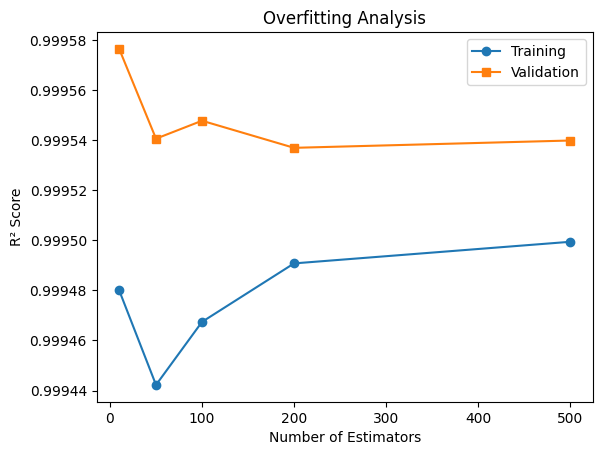

In [34]:
train_scores = []
val_scores = []
n_estimators_range = [10, 50, 100, 200, 500]

for n_est in n_estimators_range:
    rf = RandomForestRegressor(n_estimators=n_est, random_state=42, max_depth=5)

    # Cross-validation
    cv_scores = cross_val_score(rf, X_train, y_train["price"], cv=5)

    # Training score
    rf.fit(X_train, y_train["price"])
    train_score = rf.score(X_train, y_train["price"])

    train_scores.append(train_score)
    val_scores.append(cv_scores.mean())

# Plot overfitting analysis
plt.plot(n_estimators_range, train_scores, "o-", label="Training")
plt.plot(n_estimators_range, val_scores, "s-", label="Validation")
plt.xlabel("Number of Estimators")
plt.ylabel("R² Score")
plt.title("Overfitting Analysis")
plt.legend()

In [35]:
tree_model_diagnostics(
    models["RandomForest"],
    X_train,
    X_test,
    y_train["price"],
    y_test["price"],
)

Model Performance:
  R²: 0.999
  RMSE: 67106.897

Top 5 features: ['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors']

Residual Analysis:
  Mean residual: -829.832241
  Residual std: 67118.548


(0.9994858475811301, 67106.89684444474)

In [37]:
project = TreeEnsembleProject(X_train, y_train["price"])
project.run_baseline_comparison()
best_model_name = project.select_best_model()
project.generate_report()

Decision Tree: CV 1.000±0.000, Test 1.000
Random Forest: CV 1.000±0.000, Test 1.000
Extra Trees: CV 1.000±0.000, Test 1.000
Gradient Boosting: CV 1.000±0.000, Test 1.000
XGBoost: CV 1.000±0.000, Test 1.000

Best model: Extra Trees

TREE ENSEMBLE PROJECT SUMMARY

Model Rankings (by CV performance):
1. Extra Trees: 1.000±0.000
2. Random Forest: 1.000±0.000
3. Decision Tree: 1.000±0.000
4. XGBoost: 1.000±0.000
5. Gradient Boosting: 1.000±0.000

Recommended Model: Extra Trees
Cross-validation R²: 1.000
Test R²: 1.000

Key Findings:
• Best performing approach: Extra Trees
• Performance stability: 0.000 CV standard deviation
• Generalization gap: 0.000


In [40]:
bootstrap_scores = []
for i in range(100):
    # Bootstrap sample
    X_boot, y_boot = resample(X_train, y_train['price'], random_state=i)
    models['ExtraTrees'].fit(X_boot, y_boot)
    score = models['ExtraTrees'].score(X_test, y_test['price'])
    bootstrap_scores.append(score)

# Confidence interval
ci_lower = np.percentile(bootstrap_scores, 2.5)
ci_upper = np.percentile(bootstrap_scores, 97.5)
print(f"R² 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

R² 95% CI: [0.997, 0.999]
